In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import scienceplots
from models.HH import *
from models.LIF import * 
from models.Ishikevich import *
from models.morrislecar import *
from utils.load import *
from utils.compue_chi import *
from utils.compute_van_Rossum_distance import *
from utils.firing_rate import *
from utils.compute_r import * 
import matplotlib.animation as animation
from scipy.sparse import dok_matrix
import multiprocessing as mp
import scipy as sp

In [2]:
plt.style.use('science')
plt.rcParams["figure.figsize"] = (12,7)

Firing rates: Original Intensities and no noise

In [3]:
#loading up the parameters

params_HH = load_HH()
params_LIF = load_LIF()
params_IZH =load_ISH()
params_ML = load_ML()

#time parameters
t_final = 1500
dt = 0.01

#Other constant parameters
#Is = np.array([ [0, 0.05], [0.05, 0]])
Isyn = [[0, 0.0], [0.0, 0]]
Is = np.array(Isyn)
V0 = -65
tau = 0.65
y0 = [-65 , -65]
w0 = [0.0, 0.0]
u0 = [0,0]
n0 = 0
m0 = 0
h0 = 0
order = 5

#fixing random seed
np.random.seed(1234)

#generating the intensities
I_HH = np.zeros((int(t_final/dt),2))
I_IF = np.zeros((int(t_final/dt),2))
I_IZH = np.zeros((int(t_final/dt),2))
I_ML = np.zeros((int(t_final/dt),2))

I_HH[:,0] = 2.5 
I_HH[:,1] = 2.5
I_IF[:,0] = 2.5 
I_IF[:,1] = 2.5
I_IZH[:,0] = 2.5 
I_IZH[:,1] = 2.5 
I_ML[:,0] = 2.5
I_ML[:,1] = 2.5  

In [4]:
dataHH_adjust, completeHH_adjust, matrixHH_adjust = rk_simplemodel_Rossum(dt,t_final,order,[V0,V0],[n0,n0],[m0,m0],[h0,h0],*params_HH,I_HH,Is,0.0,tau)
dataIF_adjust, completeIF_adjust, matrixIF_adjust = rk_if_Rossum(dt, t_final,order,y0,*params_LIF,I_IF,Is,0.0,tau,1)
dataIZH_adjust, completeIZH_adjust, matrixIZH_adjust = rk_ish_Rossum(dt,t_final,order,y0,u0,I_IZH,Is,*params_IZH,0.0,tau)
dataML_adjust, completeML_adjust, matrixML_adjust = rk_ml_Rossum(dt,t_final,2,y0,w0,*params_ML,I_ML,Is,0.00,tau)

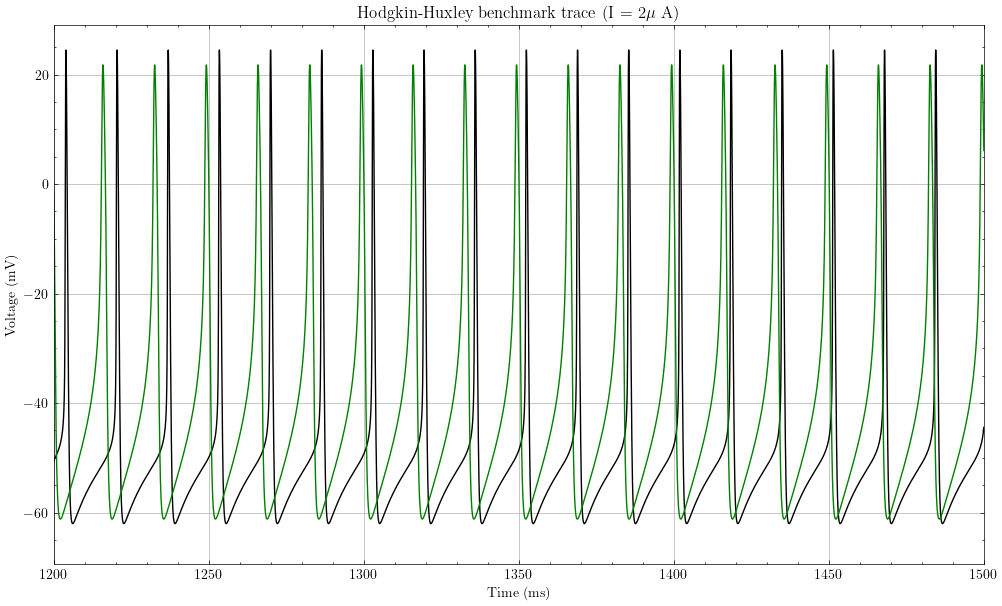

In [5]:
time = np.linspace(0,t_final,int(t_final/dt),)
plt.plot(time,dataHH_adjust[:,0], color = 'black')
plt.plot(time,dataML_adjust[:,0], color = 'green')
plt.title(r'Hodgkin-Huxley benchmark trace (I = 2$\mu$ A)')
plt.xlabel('Time (ms)')
plt.ylabel('Voltage (mV)')
plt.xlim(1200,1500)
plt.grid()

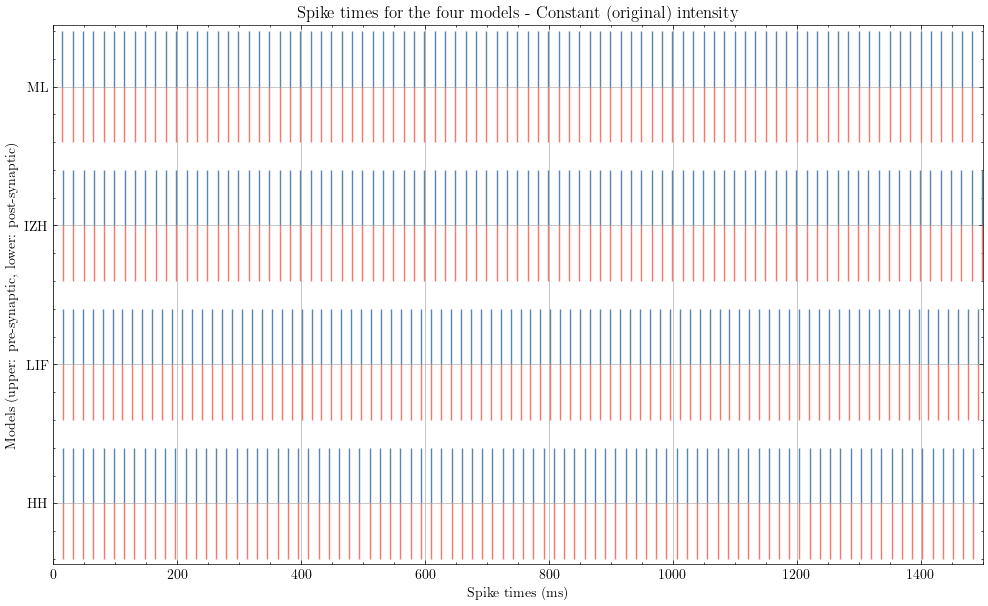

In [6]:
spike_HH_1 =  (np.argwhere(np.array(matrixHH_adjust.todense())[0,:]>0) * dt).flatten()
spike_HH_2 =  (np.argwhere(np.array(matrixHH_adjust.todense())[1,:]>0) * dt).flatten()
spike_IF_1 =  (np.argwhere(np.array(matrixIF_adjust.todense())[0,:]>0) * dt).flatten()
spike_IF_2 =  (np.argwhere(np.array(matrixIF_adjust.todense())[1,:]>0) * dt).flatten()
spike_IZH_1 =  (np.argwhere(np.array(matrixIZH_adjust.todense())[0,:]>0) * dt).flatten()
spike_IZH_2 = (np.argwhere(np.array(matrixIZH_adjust.todense())[1,:]>0) * dt).flatten()
spike_ML_1 = (np.argwhere(np.array(matrixML_adjust.todense())[0,:]>0) * dt).flatten()
spike_ML_2 = (np.argwhere(np.array(matrixML_adjust.todense())[1,:]>0) * dt).flatten()
fig, ax = plt.subplots()

ax.eventplot(spike_HH_1, color = '#5B84B1FF')
ax.eventplot(spike_HH_2,color='#FC766AFF',lineoffsets=0,label='hola')
ax.eventplot(spike_IF_2,color = '#FC766AFF',lineoffsets=2.5)
ax.eventplot(spike_IF_1, color = '#5B84B1FF', lineoffsets= 3.5)
ax.eventplot(spike_IZH_2,color = '#FC766AFF',lineoffsets= 5.0 )
ax.eventplot(spike_IZH_1, color = '#5B84B1FF', lineoffsets= 6.0)
ax.eventplot(spike_ML_2, color = '#FC766AFF', lineoffsets= 7.5)
ax.eventplot(spike_ML_1,color = '#5B84B1FF', lineoffsets= 8.5)
ax.grid()
ax.set_ylim(-0.6,9.1)
ax.set_ylabel('Models (upper: pre-synaptic, lower: post-synaptic)')
plt.yticks((0.5,3.0,5.5,8.0))
labels = [item.get_text() for item in ax.get_yticklabels()]
labels[0] = 'HH'
labels[1] = 'LIF'
labels[2] = 'IZH'
labels[3] = 'ML'

ax.set_yticklabels(labels, color = 'black')
ax.set_xlabel('Spike times (ms)')
ax.set_xlim(0,1500)

plt.title('Spike times for the four models - Constant (original) intensity')
plt.show()



In [7]:
firing_HH_pre = len(spike_HH_1)  * 1000 / t_final 
firing_HH_post = len(spike_HH_2)   *1000 / t_final
firing_IF_pre = len(spike_IF_1)  * 1000 / t_final 
firing_IF_post = len(spike_IF_2)  *1000 / t_final
firing_IZH_pre = len(spike_IZH_1)  * 1000 / t_final 
firing_IZH_post = len(spike_IZH_2)  *1000 / t_final
firing_ML_pre = len(spike_ML_1)  * 1000 / t_final 
firing_ML_post = len(spike_ML_2) *1000 / t_final

print('Pre-synaptic firing rates \n HH:',firing_HH_pre,'IF:',firing_IF_pre, 'IZH:', firing_IZH_pre, 'ML:', firing_ML_pre )
print('Post-synaptic firing rates \n HH:',firing_HH_post,'IF:',firing_IF_post, 'IZH:', firing_IZH_post, 'ML:', firing_ML_post )


Pre-synaptic firing rates 
 HH: 60.0 IF: 62.0 IZH: 60.0 ML: 60.0
Post-synaptic firing rates 
 HH: 60.0 IF: 62.0 IZH: 60.0 ML: 60.0


#### Firing rates: Roughly equal and raster plot

We are selecting initial intensity values to obtain firing rates which are approximately equal. Compare firing rates between pre and post synaptic neurons.

First, let's load the paremeters that will be constant throughout the whole experiment: the parameters of the model, the time and time interval of the simulation, and other constant parameters

In [8]:
#loading up the parameters

params_HH = load_HH()
params_LIF = load_LIF()
params_IZH =load_ISH()
params_ML = load_ML()

#time parameters
t_final = 1500
dt = 0.01

#Other constant parameters
Is = np.array([ [0, 0.05], [0.05, 0]])
V0 = -65
tau = 0.65
y0 = [-65 , -65]
w0 = [0.0, 0.0]
u0 = [0,0]
n0 = 0
m0 = 0
h0 = 0
order = 5

We'll set a fixed seed to configure the system, and create for intensities, one for each model

New Method

In [9]:
#fixing random seed
np.random.seed(1234)

#generating the intensities
I_HH = np.zeros((int(t_final/dt),2))
I_IF = np.zeros((int(t_final/dt),2))
I_IZH = np.zeros((int(t_final/dt),2))
I_ML = np.zeros((int(t_final/dt),2))
 
#the noise will be common for all cases
x1 = np.random.normal(0,5,int(t_final/dt))
x2 = np.random.normal(0,5,int(t_final/dt))
x3 = np.random.normal(0,3,int(t_final/dt))
x4 = np.random.normal(0,3,int(t_final/dt))
x5 = np.random.normal(0,11,int(t_final/dt))
x6 = np.random.normal(0,11,int(t_final/dt))

I_HH[:,0] = 2.5*(1+ 1*x1)
I_HH[:,1] = 2.5*(1+ 1*x2)
I_IF[:,0] = 2.5*(1+ 1*x3)
I_IF[:,1] = 2.5*(1+ 1*x4)
I_IZH[:,0] = 2.5*(1+ 1*x1)
I_IZH[:,1] = 2.5*(1+ 1*x2)
I_ML[:,0] = 2.5*(1+ 1*x1)
I_ML[:,1] = 2.5*(1+ 1*x2)

Compute the simulations for all of  the models, turn on synaptic coupling for all of them too

In [10]:
dataHH_adjust, completeHH_adjust, matrixHH_adjust = rk_simplemodel_Rossum(dt,t_final,order,[V0,V0],[n0,n0],[m0,m0],[h0,h0],*params_HH,I_HH,Is,0.012,tau)
dataIF_adjust, completeIF_adjust, matrixIF_adjust = rk_if_Rossum(dt, t_final,order,y0,*params_LIF,I_IF,Is,0.012,tau,0.7)
dataIZH_adjust, completeIZH_adjust, matrixIZH_adjust = rk_ish_Rossum(dt,t_final,order,y0,u0,I_IZH,Is,*params_IZH,0.04,tau)
dataML_adjust, completeML_adjust, matrixML_adjust = rk_ml_Rossum(dt,t_final,2,y0,w0,*params_ML,I_ML,Is,0.008,tau)

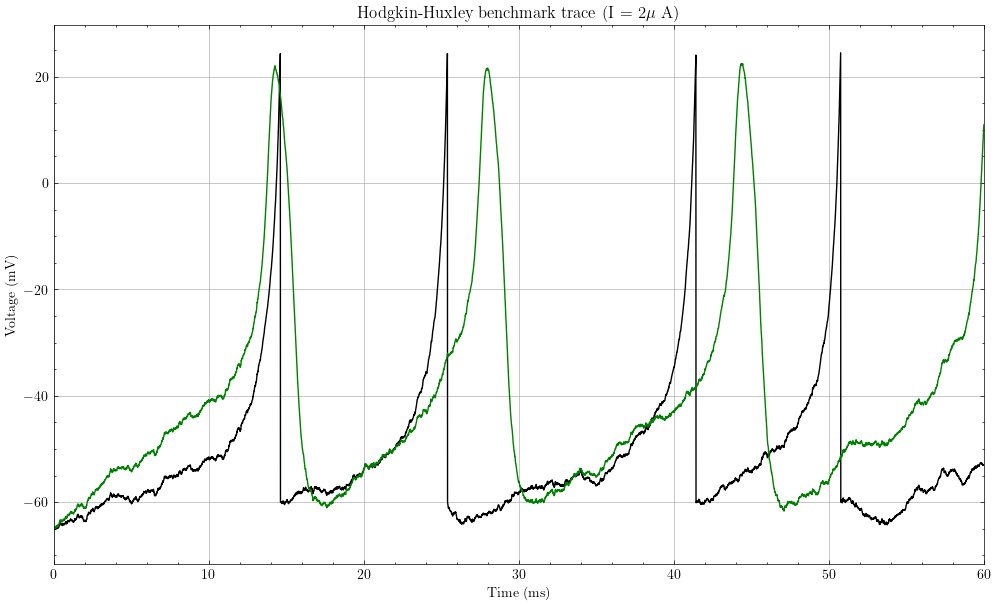

In [ ]:
time = np.linspace(0,t_final,int(t_final/dt),)
plt.plot(time,dataIZH_adjust[:,0], color = 'black')
plt.plot(time,dataML_adjust[:,0], color = 'green')
plt.title(r'Hodgkin-Huxley benchmark trace (I = 2$\mu$ A)')
plt.xlabel('Time (ms)')
plt.ylabel('Voltage (mV)')
plt.xlim(0,60)
plt.grid()

Raster plot of the spike times

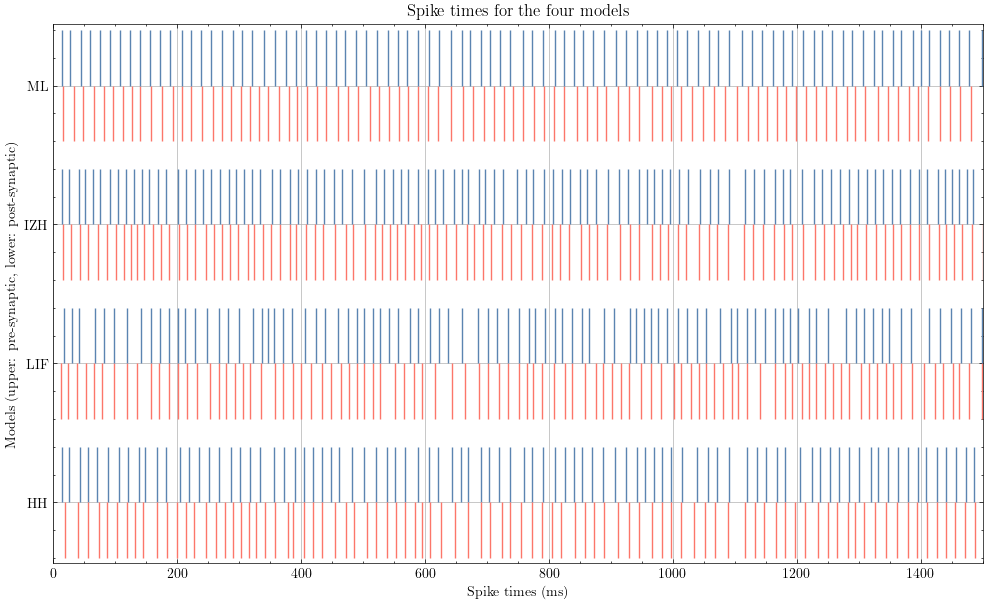

In [ ]:
spike_HH_1 =  (np.argwhere(np.array(matrixHH_adjust.todense())[0,:]>0) * dt).flatten()
spike_HH_2 =  (np.argwhere(np.array(matrixHH_adjust.todense())[1,:]>0) * dt).flatten()
spike_IF_1 =  (np.argwhere(np.array(matrixIF_adjust.todense())[0,:]>0) * dt).flatten()
spike_IF_2 =  (np.argwhere(np.array(matrixIF_adjust.todense())[1,:]>0) * dt).flatten()
spike_IZH_1 =  (np.argwhere(np.array(matrixIZH_adjust.todense())[0,:]>0) * dt).flatten()
spike_IZH_2 = (np.argwhere(np.array(matrixIZH_adjust.todense())[1,:]>0) * dt).flatten()
spike_ML_1 = (np.argwhere(np.array(matrixML_adjust.todense())[0,:]>0) * dt).flatten()
spike_ML_2 = (np.argwhere(np.array(matrixML_adjust.todense())[1,:]>0) * dt).flatten()
fig, ax = plt.subplots()

ax.eventplot(spike_HH_1, color = '#5B84B1FF')
ax.eventplot(spike_HH_2,color='#FC766AFF',lineoffsets=0,label='hola')
ax.eventplot(spike_IF_2,color = '#FC766AFF',lineoffsets=2.5)
ax.eventplot(spike_IF_1, color = '#5B84B1FF', lineoffsets= 3.5)
ax.eventplot(spike_IZH_2,color = '#FC766AFF',lineoffsets= 5.0 )
ax.eventplot(spike_IZH_1, color = '#5B84B1FF', lineoffsets= 6.0)
ax.eventplot(spike_ML_2, color = '#FC766AFF', lineoffsets= 7.5)
ax.eventplot(spike_ML_1,color = '#5B84B1FF', lineoffsets= 8.5)
ax.grid()
ax.set_ylim(-0.6,9.1)
ax.set_ylabel('Models (upper: pre-synaptic, lower: post-synaptic)')
plt.yticks((0.5,3.0,5.5,8.0))
labels = [item.get_text() for item in ax.get_yticklabels()]
labels[0] = 'HH'
labels[1] = 'LIF'
labels[2] = 'IZH'
labels[3] = 'ML'

ax.set_yticklabels(labels, color = 'black')
ax.set_xlabel('Spike times (ms)')
ax.set_xlim(0,1500)

plt.title('Spike times for the four models')
plt.show()



Compute and print firing rates

In [ ]:
firing_HH_pre = len(spike_HH_1)  * 1000 / t_final 
firing_HH_post = len(spike_HH_2)  *1000 / t_final
firing_IF_pre = len(spike_IF_1)  * 1000 / t_final 
firing_IF_post = len(spike_IF_2)  *1000 / t_final
firing_IZH_pre = len(spike_IZH_1)  * 1000 / t_final 
firing_IZH_post = len(spike_IZH_2)  *1000 / t_final
firing_ML_pre = len(spike_ML_1)  * 1000 / t_final 
firing_ML_post = len(spike_ML_2) *1000 / t_final

print('Pre-synaptic firing rates \n HH:',firing_HH_pre,'IF:',firing_IF_pre, 'IZH:', firing_IZH_pre, 'ML:', firing_ML_pre )
print('Post-synaptic firing rates \n HH:',firing_HH_post,'IF:',firing_IF_post, 'IZH:', firing_IZH_post, 'ML:', firing_ML_post )


Pre-synaptic firing rates 
 HH: 60.0 IF: 62.0 IZH: 68.66666666666667 ML: 60.666666666666664
Post-synaptic firing rates 
 HH: 60.0 IF: 64.66666666666667 IZH: 68.0 ML: 60.0


#### Benchmarks: Complete synchrony, completely out of phase

To start, we will compute the synchrony measurements for systems which have been tempered to be on the extremes of synchronisation, so we know what should be the maximum and minimum of the measurements. There are three different measurements, but for this experiment of only two neurons, we are going to ignore one of them

##### Peaks in mean voltage

We will leave here how we computed it, but it is not being currently used:

mean_voltage_HH = np.mean(data_HH,axis=1)
mean_voltage_IF = np.mean(data_IF,axis=1)
mean_voltage_IZH = np.mean(data_Ish,axis=1)
mean_voltage_ML = np.mean(data_ML,axis=1)

peaks_HH = len(np.argwhere(mean_voltage_HH>(-14)))
peaks_IF = len(np.argwhere(mean_voltage_IF>(-16)))
peaks_IZH = len(np.argwhere(mean_voltage_IZH>(-19)))
peaks_ML = len(np.argwhere(mean_voltage_ML>(-9)))


Computing a single simulation of the HH model at a constant intensity value

In [ ]:
t_final = 2000
I = np.zeros((int(t_final/dt),2))
I[:,0] = 2.5
dataHH_benchmark, completeHH_benchmark, matrixHH_benchmark = rk_simplemodel_Rossum(dt,t_final,order,[V0,V0],[n0,n0],[m0,m0],[h0,h0],*params_HH,I,Is,0,tau)

First, we will compute the $\chi$ merasurement, which is the variance of the voltage

In [ ]:
data_synchro = dataHH_benchmark
data_synchro[:,1] = dataHH_benchmark[:,0]

asyn_1 = dataHH_benchmark[900:len(dataHH_benchmark)-1,0]
asyn_2 = dataHH_benchmark[0:len(dataHH_benchmark)-1-900,0]

data_asyn = np.vstack((asyn_1,asyn_2)).T

In [ ]:
chi_syn = compute_chi(data_synchro.T)
chi_asyn = compute_chi(data_asyn.T)
print('Chi synchronous:', chi_syn, 'Chi out of phase:', chi_asyn)

Chi synchronous: 1.0000000000004168 Chi out of phase: 0.4347366267561507


Now, let's obtain the Van_Rossum distance

In [ ]:
matrix_syn = matrixHH_benchmark
matrix_syn[1,:] = matrixHH_benchmark[0,:]
t_syn = np.linspace(0,t_final,int(t_final/dt))

asyn_1 = matrixHH_benchmark[0,900:len(dataHH_benchmark)-1].todense()
asyn_2 = matrixHH_benchmark[0,0:len(dataHH_benchmark)-1-900].todense()

matrix_asyn = np.array(np.vstack((asyn_1,asyn_2)))
t_asyn = np.linspace(0,699099,int(699099))
syn_1 = matrixHH_benchmark[0,1:len(dataHH_benchmark)-1].todense()
syn_2 = matrixHH_benchmark[0,0:len(dataHH_benchmark)-1-1].todense()

matrix_syn = np.array(np.vstack((syn_1,syn_2)))
t_syn = np.linspace(0,699998,int(699998))

##### Trying to obtain an optimum time scale for the Van Rossum distance

In [ ]:
van_Rossum_opti_sym = np.zeros(10)
van_Rossum_opti_asy = np.zeros(10)
aaa = np.zeros((10,899995))
bbb =np.zeros((10,899995))
ccc = np.zeros((10,898197))
ddd = np.zeros((10,898197))

t_R = 2

for i in range(len(van_Rossum_opti_sym)):
    matrix_1, aaa[i,:],bbb[i,:] = compute_van_Rossum_distance(matrix_syn,t_syn,t_R,dt)
    van_Rossum_opti_sym[i] =matrix_1[0,1] 
    matrix_2,  ccc[i,:],ddd[i,:] = compute_van_Rossum_distance(matrix_asyn,t_asyn,t_R,dt) 
    van_Rossum_opti_asy[i]= matrix_2[0,1] 

t_R  = t_R + 3


(1200.0, 3000.0)

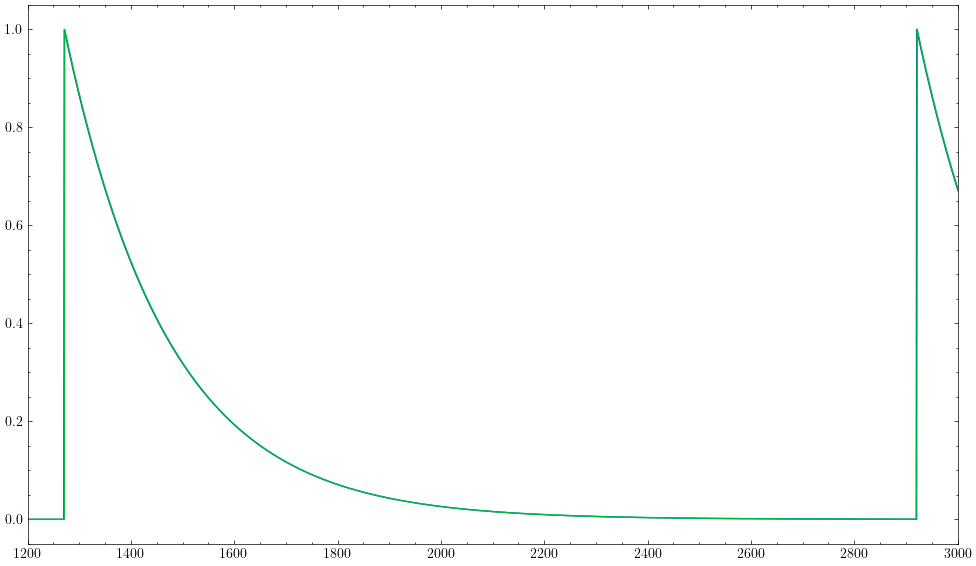

In [ ]:
plt.plot(aaa[0,:])
plt.plot(bbb[0,:])
plt.xlim(1200,3000)

(1200.0, 2400.0)

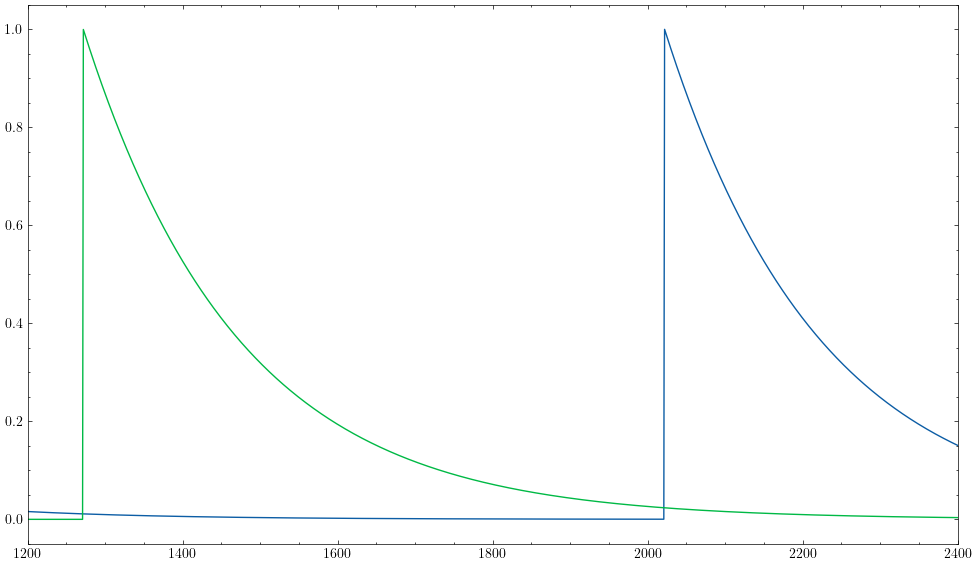

In [ ]:
plt.plot(ccc[0,:])
plt.plot(ddd[0,:])
plt.xlim(1200,2400)

In [ ]:
van_Rossum_opti_sym

array([0.77878918, 0.77878918, 0.77878918, 0.77878918, 0.77878918,
       0.77878918, 0.77878918, 0.77878918, 0.77878918, 0.77878918])

In [ ]:
van_Rossum_opti_asy

array([10.81646896, 10.81646896, 10.81646896, 10.81646896, 10.81646896,
       10.81646896, 10.81646896, 10.81646896, 10.81646896, 10.81646896])

In [ ]:
van_Rossum_syn,aa,bb = compute_van_Rossum_distance(matrix_syn,t_syn,2,dt)
van_Rossum_asyn ,cc,dd= compute_van_Rossum_distance(matrix_asyn,t_asyn,2,dt)
print('Van_Rossum synchronous:\n', van_Rossum_syn, '\n Van_Rossum out of phase:\n', van_Rossum_asyn)

Van_Rossum synchronous:
 [[0.         0.77878918]
 [0.77878918 0.        ]] 
 Van_Rossum out of phase:
 [[ 0.         10.81646896]
 [10.81646896  0.        ]]


In [ ]:
def compute_Reliability(spike_matrix,t,t_R,dt_og):
    '''
    Computes the Reliability statistic measurement of a set of spike trains
    spike_matrix - matrix containing spike trains, each row corresponds to a diffent neuron
    t - time vector (time points for columns of spike_matrix)
    t_R - time constant of the exponential kernel
    '''

    dt = (t[len(t)-1] - t[0] ) / (len(t) - 1)
    t_R = t_R / dt_og 
    if type(spike_matrix) is not np.ndarray:
        spike_matrix = np.array(spike_matrix.todense())

    joined_matrix = np.sum(spike_matrix,axis=0)
    kernel = t_R *np.exp(-t/t_R)
    
    #Convolve the spike train with kernel
    Convolved_matrix = sp.signal.convolve(joined_matrix,kernel)

    reliability = 1/t[len(t)-1] * np.trapz(np.square(Convolved_matrix),dx = dt) - (1/t[len(t)-1]/t[len(t)-1])*np.square(np.trapz(Convolved_matrix,dx =dt))

    return reliability, Convolved_matrix

In [ ]:
reliability_syn, aa = compute_Reliability(matrix_syn,t_syn,t_R,dt)
reliability_asyn , bb = compute_Reliability(matrix_asyn,t_asyn,t_R,dt) 

[False False False ... False False False]
[False False False ... False False False]


#### Experiment 1 - Random simulations and mean syncrhonisation measurements

Obtaining a mean vlaue of chi and van_Rossum distance for 5 simulations with random seeds. 

In [25]:
#loading up the parameters

params_HH = load_HH()
params_LIF = load_LIF()
params_IZH =load_ISH()
params_ML = load_ML()

#time parameters
t_final = 1500
dt = 0.01

#Other constant parameters
Is = np.array([ [0, 0.05], [0.05, 0]])
V0 = -65
tau = 0.65
y0 = [-65 , -65]
w0 = [0.0, 0.0]
u0 = [0,0]
n0 = 0
m0 = 0
h0 = 0
order = 5
#initial random seed, change
np.random.seed(1234)
n_measurements = 10

chi_HH = np.zeros(n_measurements)
chi_IF = np.zeros(n_measurements)
chi_IZH = np.zeros(n_measurements)
chi_ML = np.zeros(n_measurements)

rossum_HH = np.zeros((n_measurements,2))
rossum_IF = np.zeros((n_measurements,2))
rossum_IZH = np.zeros((n_measurements,2))
rossum_ML = np.zeros((n_measurements,2))

I_HH = np.zeros((int(t_final/dt),2))
I_IF = np.zeros((int(t_final/dt),2))
I_IZH = np.zeros((int(t_final/dt),2))
I_ML = np.zeros((int(t_final/dt),2))

firing_rate_HH = np.zeros((n_measurements,2))
firing_rate_IF = np.zeros((n_measurements,2))
firing_rate_IZH = np.zeros((n_measurements,2))
firing_rate_ML = np.zeros((n_measurements,2))



t = np.linspace(0,t_final,int(t_final/dt))
t_R = 2

saved_data_HH_on = {}
saved_data_IF_on = {}
saved_data_IZH_on = {}
saved_data_ML_on = {}

In [26]:
manager = mp.Manager()
return_dict = manager.dict()


for i in range(0,n_measurements):
    jobs = []
    #generation of random intensities
    x1 = np.random.normal(0,5,int(t_final/dt))
    x2 = np.random.normal(0,5,int(t_final/dt))
    x3 = np.random.normal(0,3,int(t_final/dt))
    x4 = np.random.normal(0,3,int(t_final/dt))

    I_HH[:,0] = 2.5*(1+ 1*x1)
    I_HH[:,1] = 2.5*(1+ 1*x2)
    I_IF[:,0] = 2.5*(1+ 1*x3)
    I_IF[:,1] = 2.5*(1+ 1*x4)
    I_IZH[:,0] = 2.5*(1+ 1*x1)
    I_IZH[:,1] = 2.5*(1+ 1*x2)
    I_ML[:,0] = 2.5*(1+ 1*x1)
    I_ML[:,1] = 2.5*(1+ 1*x2)

    #simulating the models
    proc_HH = mp.Process(target =rk_simplemodel_Rossum_parallel, args= (dt,t_final,order,[V0,V0],[n0,n0],[m0,m0],[h0,h0],*params_HH,I_HH,Is,0.012,tau,return_dict) )
    jobs.append(proc_HH)    
    proc_HH.start()

    proc_IF = mp.Process(target =rk_if_Rossum_parallel, args = (dt, t_final,order,y0,*params_LIF,I_IF,Is,0.012,tau,0.7,return_dict))
    jobs.append(proc_IF)
    proc_IF.start()
    
    proc_IZH = mp.Process(target = rk_ish_Rossum_parallel, args =(dt,t_final,order,y0,u0,I_IZH,Is,*params_IZH,0.04,tau,return_dict))
    jobs.append(proc_IZH)
    proc_IZH.start()

    proc_ML = mp.Process(target= rk_ml_Rossum_parallel, args= (dt,t_final,2,y0,w0,*params_ML,I_ML,Is,0.008,tau,return_dict))
    jobs.append(proc_ML)
    proc_ML.start()


    for proc in jobs:
        proc.join()
    
    dataHH_mean, completeHH_mean, matrixHH_mean, dataIF_mean, completeIF_mean, matrixIF_mean, dataIZH_mean, completeIZH_mean, matrixIZH_mean, dataML_mean, completeML_mean, matrixML_mean = return_dict.values()
    
    
    #computing chi 
    chi_HH[i] = compute_chi(dataHH_mean.T)
    chi_IF[i] = compute_chi(dataIF_mean.T)
    chi_IZH[i] = compute_chi(dataIZH_mean.T)
    chi_ML[i] = compute_chi(dataML_mean.T)

    #computing firing rate
    firing_rate_HH[i] = compute_firing_rate(matrixHH_mean,dt,t_final)
    firing_rate_IF[i] = compute_firing_rate(matrixIF_mean,dt,t_final)
    firing_rate_IZH[i] = compute_firing_rate(matrixIZH_mean,dt,t_final)
    firing_rate_ML[i] = compute_firing_rate(matrixML_mean,dt,t_final)

    #computing van_Rossum distance
    rossum_HH[i] = compute_van_Rossum_distance_2(matrixHH_mean,t,t_R,dt).flatten()[1:3] / firing_rate_HH[i]
    rossum_IF[i] = compute_van_Rossum_distance_2(matrixIF_mean,t,t_R,dt).flatten()[1:3] / firing_rate_IF[i]
    rossum_IZH[i] = compute_van_Rossum_distance_2(matrixIZH_mean,t,t_R,dt).flatten()[1:3] / firing_rate_IZH[i]
    rossum_ML[i] = compute_van_Rossum_distance_2(matrixML_mean,t,t_R,dt).flatten()[1:3] / firing_rate_ML[i]


chi_HH_total = np.mean(chi_HH),np.std(chi_HH)
chi_IF_total = np.mean(chi_IF),np.std(chi_IF)
chi_IZH_total= np.mean(chi_IZH),np.std(chi_IZH)
chi_ML_total = np.mean(chi_ML),np.std(chi_ML)

rossum_HH_total1 = np.mean(rossum_HH[:,0]), np.std(rossum_HH[:,0])
rossum_HH_total2 = np.mean(rossum_HH[:,1]), np.std(rossum_HH[:,1])

rossum_IF_total1 = np.mean(rossum_IF[:,0]), np.std(rossum_IF[:,0])
rossum_IF_total2 = np.mean(rossum_IF[:,1]), np.std(rossum_IF[:,1])

rossum_IZH_total1 = np.mean(rossum_IZH[:,0]), np.std(rossum_IZH[:,0])
rossum_IZH_total2 = np.mean(rossum_IZH[:,1]), np.std(rossum_IZH[:,1])

rossum_ML_total1 = np.mean(rossum_ML[:,0]), np.std(rossum_ML[:,0])
rossum_ML_total2 = np.mean(rossum_ML[:,1]), np.std(rossum_ML[:,1])

#### Experiment 2 - Random simulations with gap junction off

Repeat exactly the same experiment than before, but this time changing the gap junction to 0 for all models

In [27]:
#loading up the parameters

params_HH = load_HH()
params_LIF = load_LIF()
params_IZH =load_ISH()
params_ML = load_ML()

#time parameters
t_final = 1500
dt = 0.01

#Other constant parameters
Is = np.array([ [0, 0.05], [0.05, 0]])
V0 = -65
tau = 0.65
y0 = [-65 , -65]
w0 = [0.0, 0.0]
u0 = [0,0]
n0 = 0
m0 = 0
h0 = 0
order = 5

In [28]:
#initial random seed, change
np.random.seed(1234)
n_measurements = 10

chi_HH_off = np.zeros(n_measurements)
chi_IF_off = np.zeros(n_measurements)
chi_IZH_off = np.zeros(n_measurements)
chi_ML_off = np.zeros(n_measurements)

rossum_HH_off = np.zeros((n_measurements,2))
rossum_IF_off = np.zeros((n_measurements,2))
rossum_IZH_off = np.zeros((n_measurements,2))
rossum_ML_off = np.zeros((n_measurements,2))

I_HH = np.zeros((int(t_final/dt),2))
I_IF = np.zeros((int(t_final/dt),2))
I_IZH = np.zeros((int(t_final/dt),2))
I_ML = np.zeros((int(t_final/dt),2))

firing_rate_HH_off = np.zeros((n_measurements,2))
firing_rate_IF_off = np.zeros((n_measurements,2))
firing_rate_IZH_off = np.zeros((n_measurements,2))
firing_rate_ML_off = np.zeros((n_measurements,2))



t = np.linspace(0,t_final,int(t_final/dt))
t_R = 2

for i in range(0,n_measurements):

    #generation of random intensities
    x1 = np.random.normal(0,5,int(t_final/dt))
    x2 = np.random.normal(0,5,int(t_final/dt))
    x3 = np.random.normal(0,3,int(t_final/dt))
    x4 = np.random.normal(0,3,int(t_final/dt))

    I_HH[:,0] = 2.5*(1+ 1*x1)
    I_HH[:,1] = 2.5*(1+ 1*x2)
    I_IF[:,0] = 2.5*(1+ 1*x3)
    I_IF[:,1] = 2.5*(1+ 1*x4)
    I_IZH[:,0] = 2.5*(1+ 1*x1)
    I_IZH[:,1] = 2.5*(1+ 1*x2)
    I_ML[:,0] = 2.5*(1+ 1*x1)
    I_ML[:,1] = 2.5*(1+ 1*x2)

    #simulating the models
    proc_HH = mp.Process(target =rk_simplemodel_Rossum_parallel, args= (dt,t_final,order,[V0,V0],[n0,n0],[m0,m0],[h0,h0],*params_HH,I_HH,Is,0.0,tau,return_dict) )
    jobs.append(proc_HH)    
    proc_HH.start()

    proc_IF = mp.Process(target =rk_if_Rossum_parallel, args = (dt, t_final,order,y0,*params_LIF,I_IF,Is,0.012,tau,0.0,return_dict))
    jobs.append(proc_IF)
    proc_IF.start()
    
    proc_IZH = mp.Process(target = rk_ish_Rossum_parallel, args =(dt,t_final,order,y0,u0,I_IZH,Is,*params_IZH,0.0,tau,return_dict))
    jobs.append(proc_IZH)
    proc_IZH.start()

    proc_ML = mp.Process(target= rk_ml_Rossum_parallel, args= (dt,t_final,2,y0,w0,*params_ML,I_ML,Is,0.0,tau,return_dict))
    jobs.append(proc_ML)
    proc_ML.start()


    for proc in jobs:
        proc.join()
    
    dataHH_off, completeHH_off, matrixHH_off, dataIF_off, completeIF_off, matrixIF_off, dataIZH_off, completeIZH_off, matrixIZH_off, dataML_off, completeML_off, matrixML_off = return_dict.values()


    #computing chi 
    chi_HH_off[i] = compute_chi(dataHH_off.T)
    chi_IF_off[i] = compute_chi(dataIF_off.T)
    chi_IZH_off[i] = compute_chi(dataIZH_off.T)
    chi_ML_off[i] = compute_chi(dataML_off.T)

    #computing firing rate
    firing_rate_HH_off[i] = compute_firing_rate(matrixHH_mean,dt,t_final)
    firing_rate_IF_off[i] = compute_firing_rate(matrixIF_mean,dt,t_final)
    firing_rate_IZH_off[i] = compute_firing_rate(matrixIZH_mean,dt,t_final)
    firing_rate_ML_off[i] = compute_firing_rate(matrixML_mean,dt,t_final)

    #computing van_Rossum distance
    rossum_HH_off[i] = compute_van_Rossum_distance_2(matrixHH_off,t,t_R,dt).flatten()[1:3] / firing_rate_HH_off[i]
    rossum_IF_off[i] = compute_van_Rossum_distance_2(matrixIF_off,t,t_R,dt).flatten()[1:3] / firing_rate_IF_off[i]
    rossum_IZH_off[i] = compute_van_Rossum_distance_2(matrixIZH_off,t,t_R,dt).flatten()[1:3] / firing_rate_IZH_off[i]
    rossum_ML_off[i] = compute_van_Rossum_distance_2(matrixML_off,t,t_R,dt).flatten()[1:3] / firing_rate_ML_off[i]


chi_HH_total_off = np.mean(chi_HH_off),np.std(chi_HH_off)
chi_IF_total_off = np.mean(chi_IF_off),np.std(chi_IF_off)
chi_IZH_total_off= np.mean(chi_IZH_off),np.std(chi_IZH_off)
chi_ML_total_off = np.mean(chi_ML_off),np.std(chi_ML_off)

firing_HH_off = np.mean(firing_rate_HH_off)
firing_IF_off = np.mean(firing_rate_IF_off)
firing_IZH_off = np.mean(firing_rate_IZH_off)
firing_ML_off = np.mean(firing_rate_ML_off)

rossum_HH_total1_off = np.mean(rossum_HH_off[:,0]), np.std(rossum_HH_off[:,0])
rossum_HH_total2_off = np.mean(rossum_HH_off[:,1]), np.std(rossum_HH_off[:,1])

rossum_IF_total1_off = np.mean(rossum_IF_off[:,0]), np.std(rossum_IF_off[:,0])
rossum_IF_total2_off = np.mean(rossum_IF_off[:,1]), np.std(rossum_IF_off[:,1])

rossum_IZH_total1_off = np.mean(rossum_IZH_off[:,0]), np.std(rossum_IZH_off[:,0])
rossum_IZH_total2_off = np.mean(rossum_IZH_off[:,1]), np.std(rossum_IZH_off[:,1])

rossum_ML_total1_off = np.mean(rossum_ML_off[:,0]), np.std(rossum_ML_off[:,0])
rossum_ML_total2_off = np.mean(rossum_ML_off[:,1]), np.std(rossum_ML_off[:,1])

##### Presenting the results

In [29]:
print('HH model: \n Chi measurement for gap junction on:', chi_HH_total[0], '+-', chi_HH_total[1], '\n Chi measurement for gap junction off:', chi_HH_total_off[0], '+-', chi_HH_total_off[1])
print(' Van Rossum distance for gap junction on (cell 1):', rossum_HH_total1[0], '+-', rossum_HH_total1[1], '\n Van Rossum distance for gap junction off (cell 1)', rossum_HH_total1_off[0], '+-', rossum_HH_total1_off[1], '\n')

print('LIF model: \n Chi measurement for gap junction on:', chi_IF_total[0], '+-', chi_IF_total[1], '\n Chi measurement for gap junction off:', chi_IF_total_off[0], '+-', chi_IF_total_off[1], '\n')
print(' Van Rossum distance for gap junction on (cell 1):', rossum_IF_total1[0], '+-', rossum_IF_total1[1],  '\n Van Rossum distance for gap junction off (cell 1)', rossum_IF_total1_off[0], '+-', rossum_IF_total1_off[1], '\n')

print('IZH model: \n Chi measurement for gap junction on:', chi_IZH_total[0], '+-', chi_IZH_total[1], '\n Chi measurement for gap junction off:', chi_IZH_total_off[0], '+-', chi_IZH_total_off[1], '\n')
print(' Van Rossum distance for gap junction on (cell 1):', rossum_IZH_total1[0], '+-', rossum_IZH_total1[1],  '\n Van Rossum distance for gap junction off (cell 1)', rossum_IZH_total1_off[0], '+-', rossum_IZH_total1_off[1], '\n')

print('ML model: \n Chi measurement for gap junction on:', chi_ML_total[0], '+-', chi_ML_total[1], '\n Chi measurement for gap junction off:', chi_ML_total_off[0], '+-', chi_ML_total_off[1], '\n')
print(' Van Rossum distance for gap junction on (cell 1):', rossum_ML_total1[0], '+-', rossum_ML_total1[1],  '\n Van Rossum distance for gap junction off (cell 1)', rossum_ML_total1_off[0], '+-', rossum_ML_total1_off[1], '\n')

HH model: 
 Chi measurement for gap junction on: 0.5490303072009206 +- 0.04315138718060524 
 Chi measurement for gap junction off: 0.5029602804436094 +- 0.04260496658801947
 Van Rossum distance for gap junction on (cell 1): 0.02297774664952283 +- 0.0029308273408264565 
 Van Rossum distance for gap junction off (cell 1) 0.02573216276154785 +- 0.0016539690199005447 

LIF model: 
 Chi measurement for gap junction on: 0.5167993486508351 +- 0.02074825033027054 
 Chi measurement for gap junction off: 0.4990750968201828 +- 0.025169908195776407 

 Van Rossum distance for gap junction on (cell 1): 0.02401024530021218 +- 0.0020589347415404693 
 Van Rossum distance for gap junction off (cell 1) 0.030261277338815895 +- 0.004970705602089623 

IZH model: 
 Chi measurement for gap junction on: 0.5459894688008131 +- 0.029941131234436147 
 Chi measurement for gap junction off: 0.49310013776673456 +- 0.021189768474279193 

 Van Rossum distance for gap junction on (cell 1): 0.03293810780926179 +- 0.00560

#### Experiment 3- Study in function of the gap junction value

In [30]:
#loading up the parameters

params_HH = load_HH()
params_LIF = load_LIF()
params_IZH =load_ISH()
params_ML = load_ML()

#time parameters
t_final = 1500
dt = 0.01

#Other constant parameters
Is = np.array([ [0, 0.05], [0.05, 0]])
V0 = -65
tau = 0.65
y0 = [-65 , -65]
w0 = [0.0, 0.0]
u0 = [0,0]
n0 = 0
m0 = 0
h0 = 0
order = 5

In [31]:
#initial random seed, change
np.random.seed(1234)
n_measurements = 10

chi_HH = np.zeros(n_measurements)
chi_IF = np.zeros(n_measurements)
chi_IZH = np.zeros(n_measurements)
chi_ML = np.zeros(n_measurements)

rossum_HH = np.zeros((n_measurements,2))
rossum_IF = np.zeros((n_measurements,2))
rossum_IZH = np.zeros((n_measurements,2))
rossum_ML = np.zeros((n_measurements,2))

I_HH = np.zeros((int(t_final/dt),2))
I_IF = np.zeros((int(t_final/dt),2))
I_IZH = np.zeros((int(t_final/dt),2))
I_ML = np.zeros((int(t_final/dt),2))

chi_HH_k = np.zeros((5,2))
chi_IF_k = np.zeros((5,2))
chi_IZH_k = np.zeros((5,2))
chi_ML_k = np.zeros((5,2))

chi_rel_HH_k = np.zeros((5,2))
chi_rel_IF_k = np.zeros((5,2))
chi_rel_IZH_k = np.zeros((5,2))
chi_rel_ML_k = np.zeros((5,2))


rossum_HH_k = np.zeros((5,2))
rossum_IF_k = np.zeros((5,2))
rossum_IZH_k = np.zeros((5,2))
rossum_ML_k = np.zeros((5,2))

firing_rate_HH = np.zeros(n_measurements)
firing_rate_IF = np.zeros(n_measurements)
firing_rate_IZH = np.zeros(n_measurements)
firing_rate_ML = np.zeros(n_measurements)

firing_rate_HH_k = np.zeros(5)
firing_rate_IF_k = np.zeros(5)
firing_rate_IZH_k = np.zeros(5)
firing_rate_ML_k = np.zeros(5)

save_HH_k = {}
matrix_HH_k = {}
save_IF_k = {}
matrix_IF_k = {}
save_IZH_k = {}
matrix_IZH_k = {}
save_ML_k = {}
matrix_ML_k = {}



t = np.linspace(0,t_final,int(t_final/dt))
t_R = 2

k = 0.008

for j in range(0,5):

    for i in range(0,n_measurements):

        #generation of random intensities
        x1 = np.random.normal(0,5,int(t_final/dt))
        x2 = np.random.normal(0,5,int(t_final/dt))
        x3 = np.random.normal(0,3,int(t_final/dt))
        x4 = np.random.normal(0,3,int(t_final/dt))

        I_HH[:,0] = 2.5*(1+ 1*x1)
        I_HH[:,1] = 2.5*(1+ 1*x2)
        I_IF[:,0] = 2.5*(1+ 1*x3)
        I_IF[:,1] = 2.5*(1+ 1*x4)
        I_IZH[:,0] = 2.5*(1+ 1*x1)
        I_IZH[:,1] = 2.5*(1+ 1*x2)
        I_ML[:,0] = 2.5*(1+ 1*x1)
        I_ML[:,1] = 2.5*(1+ 1*x2)

        #simulating the models
        proc_HH = mp.Process(target =rk_simplemodel_Rossum_parallel, args= (dt,t_final,order,[V0,V0],[n0,n0],[m0,m0],[h0,h0],*params_HH,I_HH,Is,k,tau,return_dict) )
        jobs.append(proc_HH)    
        proc_HH.start()

        proc_IF = mp.Process(target =rk_if_Rossum_parallel, args = (dt, t_final,order,y0,*params_LIF,I_IF,Is,0.012,tau,k,return_dict))
        jobs.append(proc_IF)
        proc_IF.start()
    
        proc_IZH = mp.Process(target = rk_ish_Rossum_parallel, args =(dt,t_final,order,y0,u0,I_IZH,Is,*params_IZH,k,tau,return_dict))
        jobs.append(proc_IZH)
        proc_IZH.start()

        proc_ML = mp.Process(target= rk_ml_Rossum_parallel, args= (dt,t_final,2,y0,w0,*params_ML,I_ML,Is,k,tau,return_dict))
        jobs.append(proc_ML)
        proc_ML.start()


        for proc in jobs:
            proc.join()
    
        dataHH_k, completeHH_k, matrixHH_k, dataIF_k, completeIF_k, matrixIF_k, dataIZH_k, completeIZH_k, matrixIZH_k, dataML_k, completeML_k, matrixML_k = return_dict.values()


        #computing chi 
        chi_HH[i] = compute_chi(dataHH_k.T) - chi_HH_total_off[0]
        chi_IF[i] = compute_chi(dataIF_k.T) - chi_IF_total_off[0]
        chi_IZH[i] = compute_chi(dataIZH_k.T)  - chi_IZH_total_off[0]
        chi_ML[i] = compute_chi(dataML_k.T) - chi_ML_total_off[0]

        #computing firing rate
        firing_rate_HH[i] = compute_firing_rate(matrixHH_k,dt,t_final)
        firing_rate_IF[i] = compute_firing_rate(matrixIF_k,dt,t_final)
        firing_rate_IZH[i] = compute_firing_rate(matrixIZH_k,dt,t_final)
        firing_rate_ML[i] = compute_firing_rate(matrixML_k,dt,t_final)

        #computing van_Rossum distance
        rossum_HH[i] = compute_van_Rossum_distance_2(matrixHH_k,t,t_R,dt).flatten()[1:3] / firing_rate_HH[i] - rossum_HH_total1_off[0]
        rossum_IF[i] = compute_van_Rossum_distance_2(matrixIF_k,t,t_R,dt).flatten()[1:3] / firing_rate_IF[i] - rossum_IF_total1_off[0]
        rossum_IZH[i] = compute_van_Rossum_distance_2(matrixIZH_k,t,t_R,dt).flatten()[1:3] / firing_rate_IZH[i] - rossum_IZH_total1_off[0]
        rossum_ML[i] = compute_van_Rossum_distance_2(matrixML_k,t,t_R,dt).flatten()[1:3] / firing_rate_ML[i] - rossum_ML_total1_off[0]

    save_HH_k[j] = dataHH_k
    matrix_HH_k[j] = matrix_HH_k.todense()
    save_IF_k[j] = dataIF_k
    matrix_IF_k[j] = matrix_IF_k.todense()
    save_IZH_k[j] = dataIZH_k
    matrix_IZH_k[j] = matrix_IZH_k.todense()
    save_ML_k[j] = dataML_k
    matrix_ML_k[j] = matrix_ML_k.todense()

    chi_HH_k[j] = np.mean(chi_HH),np.std(chi_HH)
    chi_IF_k[j] = np.mean(chi_IF),np.std(chi_IF)
    chi_IZH_k[j]= np.mean(chi_IZH),np.std(chi_IZH)
    chi_ML_k[j] = np.mean(chi_ML),np.std(chi_ML)

    firing_rate_HH_k[j] = np.mean(firing_rate_HH)
    firing_rate_IF_k[j] = np.mean(firing_rate_IF)
    firing_rate_IZH_k[j] = np.mean(firing_rate_IZH)
    firing_rate_ML_k[j] = np.mean(firing_rate_ML)

    rossum_HH_k[j] = np.mean(rossum_HH[:,0]), np.std(rossum_HH[:,0])

    rossum_IF_k[j] = np.mean(rossum_IF[:,0]), np.std(rossum_IF[:,0])

    rossum_IZH_k[j] = np.mean(rossum_IZH[:,0]), np.std(rossum_IZH[:,0])

    rossum_ML_k[j] = np.mean(rossum_ML[:,0]), np.std(rossum_ML[:,0])

    k = k +0.01

#### Presenting the results

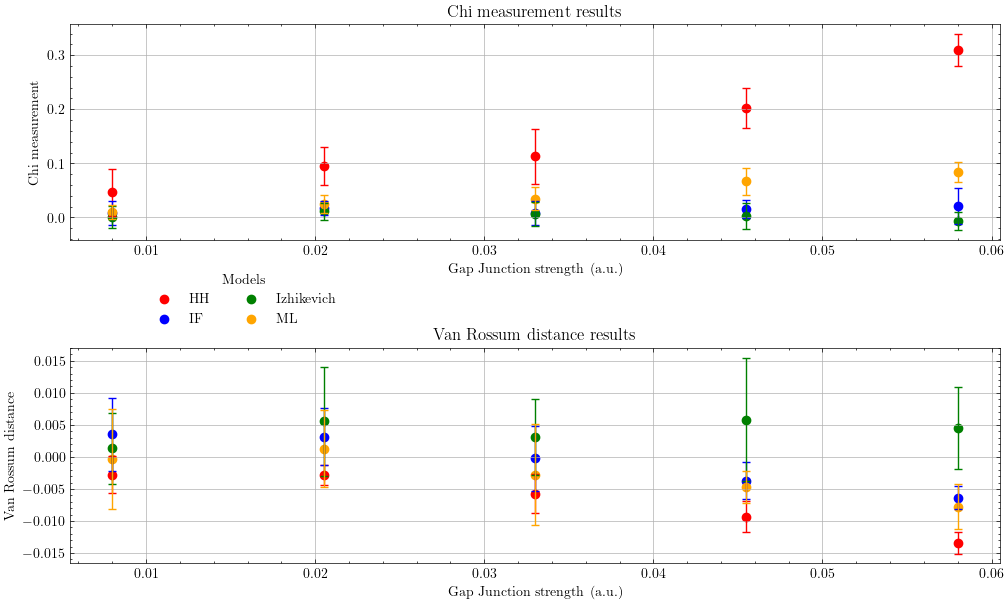

In [32]:
k = np.linspace(0.008,0.058,5)
fig, (ax1, ax2) = plt.subplots(2,1)

plt.title('Experiment 3 - Evolution of the synchronisation in function of gap junction strength')
fig.subplots_adjust(hspace=0.5)
ax1.set_xlabel('Gap Junction strength (a.u.)')
ax2.set_xlabel('Gap Junction strength (a.u.) ')
ax1.set_ylabel('Chi measurement')
ax2.set_ylabel('Van Rossum distance')
ax1.tick_params(axis = 'y')
ax2.tick_params(axis = 'y')

ax1.title.set_text('Chi measurement results')
ax2.title.set_text('Van Rossum distance results')

ln1 = ax1.scatter(k,chi_HH_k[:,0],color = 'r', label = 'HH')
ax1.errorbar(k,chi_HH_k[:,0],yerr=chi_HH_k[:,1], fmt='none',capsize=3,color = 'r')
ln2 = ax1.scatter(k,chi_IF_k[:,0],color = 'b', label = 'IF')
ax1.errorbar(k,chi_IF_k[:,0],yerr=chi_IF_k[:,1], fmt='none',capsize=3,color = 'b')
ln3 = ax1.scatter(k,chi_IZH_k[:,0],color = 'g', label = 'Izhikevich')
ax1.errorbar(k,chi_IZH_k[:,0],yerr=chi_IZH_k[:,1], fmt='none',capsize=3,color = 'g')
ln4 = ax1.scatter(k,chi_ML_k[:,0],color = 'orange', label = 'ML')
ax1.errorbar(k,chi_ML_k[:,0],yerr=chi_ML_k[:,1], fmt='none',capsize=3,color = 'orange')


ax2.scatter(k,rossum_HH_k[:,0],color = 'r', label = 'HH')
ax2.errorbar(k,rossum_HH_k[:,0],yerr=rossum_HH_k[:,1], fmt='none',capsize=3,color = 'r')
ax2.scatter(k,rossum_IF_k[:,0],color = 'b', label = 'IF')
ax2.errorbar(k,rossum_IF_k[:,0],yerr=rossum_IF_k[:,1], fmt='none',capsize=3,color = 'b')
ax2.scatter(k,rossum_IZH_k[:,0],color = 'g', label = 'Izhikevich')
ax2.errorbar(k,rossum_IZH_k[:,0],yerr=rossum_IZH_k[:,1], fmt='none',capsize=3,color = 'g')
ax2.scatter(k,rossum_ML_k[:,0],color = 'orange', label = 'ML')
ax2.errorbar(k,rossum_ML_k[:,0],yerr=rossum_ML_k[:,1], fmt='none',capsize=3,color = 'orange')


ax1.grid()
ax2.grid()
ax1.legend(title='Models',bbox_to_anchor =( 0.3,-0.1), ncols = 2 )
plt.show()

##### Print examples of the voltage traces if needed

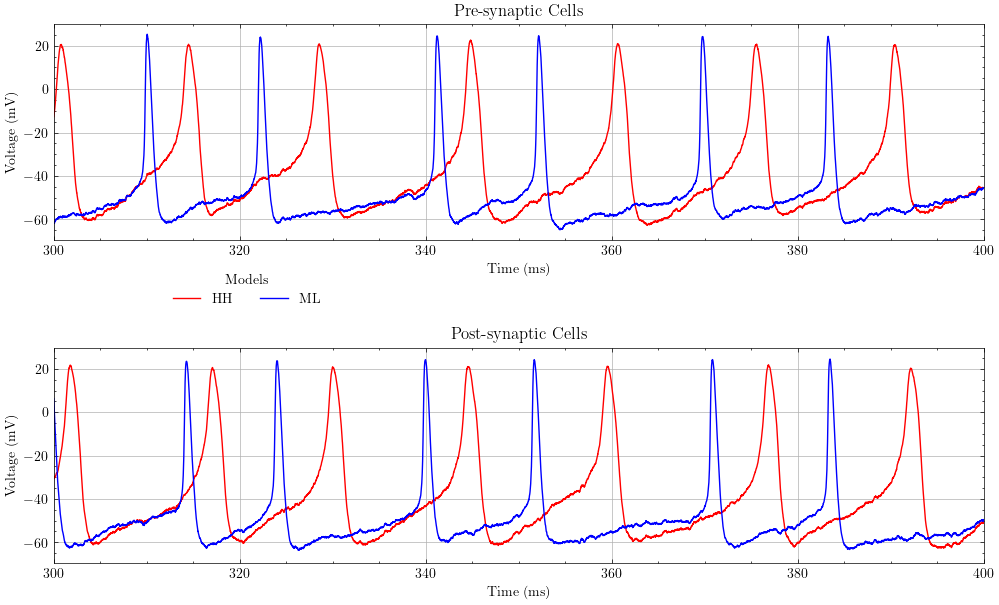

In [45]:
k = np.linspace(0.008,0.058,5)
fig, (ax1, ax2) = plt.subplots(2,1)

plt.title('Experiment 3 - Volt traces Comparisson')
fig.subplots_adjust(hspace=0.5)
ax1.set_xlabel('Time (ms)')
ax2.set_xlabel('Time (ms) ')
ax1.set_ylabel('Voltage (mV)')
ax2.set_ylabel('Voltage (mV)')
ax1.tick_params(axis = 'y')
ax2.tick_params(axis = 'y')

ax1.title.set_text('Pre-synaptic Cells')
ax2.title.set_text('Post-synaptic Cells')

ax1.plot(t,save_HH_k[4][:,0],color = 'r', label = 'HH')
ax1.plot(t,save_ML_k[4][:,0],color = 'b', label = 'ML')
ax1.set_xlim(300,400)


ax2.plot(t,save_HH_k[4][:,1],color = 'r', label = 'HH')
ax2.plot(t,save_ML_k[4][:,1],color = 'b', label = 'ML')
ax2.set_xlim(300,400)

ax1.grid()
ax2.grid()
ax1.legend(title='Models',bbox_to_anchor =( 0.3,-0.1), ncols = 2 )
plt.show()

##### Test With raster plots

In [46]:
spike_HH_1 =  (np.argwhere(np.array(matrix_HH_k[4])[0,:]>0) * dt).flatten()
spike_HH_2 =  (np.argwhere(np.array(matrix_HH_k[4])[1,:]>0) * dt).flatten()
spike_IF_1 =  (np.argwhere(np.array(matrix_IF_k[4])[0,:]>0) * dt).flatten()
spike_IF_2 =  (np.argwhere(np.array(matrix_IF_k[4])[1,:]>0) * dt).flatten()
spike_IZH_1 =  (np.argwhere(np.array(matrix_IZH_k[4])[0,:]>0) * dt).flatten()
spike_IZH_2 = (np.argwhere(np.array(matrix_IZH_k[4])[1,:]>0) * dt).flatten()
spike_ML_1 = (np.argwhere(np.array(matrix_ML_k[4])[0,:]>0) * dt).flatten()
spike_ML_2 = (np.argwhere(np.array(matrix_ML_k[4])[1,:]>0) * dt).flatten()
fig, ax = plt.subplots()

ax.eventplot(spike_HH_1, color = '#5B84B1FF')
ax.eventplot(spike_HH_2,color='#FC766AFF',lineoffsets=0,label='hola')
ax.eventplot(spike_IF_2,color = '#FC766AFF',lineoffsets=2.5)
ax.eventplot(spike_IF_1, color = '#5B84B1FF', lineoffsets= 3.5)
ax.eventplot(spike_IZH_2,color = '#FC766AFF',lineoffsets= 5.0 )
ax.eventplot(spike_IZH_1, color = '#5B84B1FF', lineoffsets= 6.0)
ax.eventplot(spike_ML_2, color = '#FC766AFF', lineoffsets= 7.5)
ax.eventplot(spike_ML_1,color = '#5B84B1FF', lineoffsets= 8.5)
ax.grid()
ax.set_ylim(-0.6,9.1)
ax.set_ylabel('Models (upper: pre-synaptic, lower: post-synaptic)')
plt.yticks((0.5,3.0,5.5,8.0))
labels = [item.get_text() for item in ax.get_yticklabels()]
labels[0] = 'HH'
labels[1] = 'LIF'
labels[2] = 'IZH'
labels[3] = 'ML'

ax.set_yticklabels(labels, color = 'black')
ax.set_xlabel('Spike times (ms)')
ax.set_xlim(0,1500)

plt.title('Spike times for the four models-test for k = 0.058')
plt.show()

AttributeError: 'dict' object has no attribute 'todense'

#### Experiment 4 - Variation of the intensity of the noise

In [33]:
#loading up the parameters

params_HH = load_HH()
params_LIF = load_LIF()
params_IZH =load_ISH()
params_ML = load_ML()

#time parameters
t_final = 1500
dt = 0.01

#Other constant parameters
Is = np.array([ [0, 0.05], [0.05, 0]])
V0 = -60
tau = 0.65
y0 = [-60 , -60]
w0 = [0.0007223855976593603, 0.0007223855976593603]
u0 = [0,0]
n0 = 0.2 
m0 = 0.1 
h0 = 0.6 
order = 5

In [34]:
#initial random seed, change
np.random.seed(1234)
n_measurements = 10

chi_HH = np.zeros(n_measurements)
chi_IF = np.zeros(n_measurements)
chi_IZH = np.zeros(n_measurements)
chi_ML = np.zeros(n_measurements)

rossum_HH = np.zeros((n_measurements,2))
rossum_IF = np.zeros((n_measurements,2))
rossum_IZH = np.zeros((n_measurements,2))
rossum_ML = np.zeros((n_measurements,2))

I_HH = np.zeros((int(t_final/dt),2))
I_IF = np.zeros((int(t_final/dt),2))
I_IZH = np.zeros((int(t_final/dt),2))
I_ML = np.zeros((int(t_final/dt),2))

chi_HH_noise = np.zeros((5,2))
chi_IF_noise = np.zeros((5,2))
chi_IZH_noise = np.zeros((5,2))
chi_ML_noise = np.zeros((5,2))

rossum_HH_noise = np.zeros((5,2))
rossum_IF_noise = np.zeros((5,2))
rossum_IZH_noise = np.zeros((5,2))
rossum_ML_noise = np.zeros((5,2))

firing_rate_HH = np.zeros(n_measurements)
firing_rate_IF = np.zeros(n_measurements)
firing_rate_IZH = np.zeros(n_measurements)
firing_rate_ML = np.zeros(n_measurements)

save_HH_noise = {}
matrix_HH_noise = {}
save_IF_noise = {}
matrix_IF_noise = {}
save_IZH_noise = {}
matrix_IZH_noise = {}
save_ML_noise = {}
matrix_ML_noise = {}

t = np.linspace(0,t_final,int(t_final/dt))
t_R = 2

noise = 3

for j in range(0,5):

    for i in range(0,n_measurements):

        #generation of random intensities
        x1 = np.random.normal(0,noise,int(t_final/dt))
        x2 = np.random.normal(0,noise,int(t_final/dt))
        I_HH[:,0] = 2.5*(1+ 1*x1)
        I_HH[:,1] = 2.5*(1+ 1*x2)
        I_IF[:,0] = 2.5*(1+ 1*x1)
        I_IF[:,1] = 2.5*(1+ 1*x2)
        I_IZH[:,0] = 2.5*(1+ 1*x1)
        I_IZH[:,1] = 2.5*(1+ 1*x2)
        I_ML[:,0] = 2.5*(1+ 1*x1)
        I_ML[:,1] = 2.5*(1+ 1*x2)
        
        #simulating the models
        proc_HH = mp.Process(target =rk_simplemodel_Rossum_parallel, args= (dt,t_final,order,[V0,V0],[n0,n0],[m0,m0],[h0,h0],*params_HH,I_HH,Is,0.012,tau,return_dict) )
        jobs.append(proc_HH)    
        proc_HH.start()

        proc_IF = mp.Process(target =rk_if_Rossum_parallel, args = (dt, t_final,order,y0,*params_LIF,I_IF,Is,0.012,tau,0.7,return_dict))
        jobs.append(proc_IF)
        proc_IF.start()
    
        proc_IZH = mp.Process(target = rk_ish_Rossum_parallel, args =(dt,t_final,order,y0,u0,I_IZH,Is,*params_IZH,0.04,tau,return_dict))
        jobs.append(proc_IZH)
        proc_IZH.start()

        proc_ML = mp.Process(target= rk_ml_Rossum_parallel, args= (dt,t_final,2,y0,w0,*params_ML,I_ML,Is,0.008,tau,return_dict))
        jobs.append(proc_ML)
        proc_ML.start()


        for proc in jobs:
            proc.join()
    
        dataHH_mean, completeHH_mean, matrixHH_mean, dataIF_mean, completeIF_mean, matrixIF_mean, dataIZH_mean, completeIZH_mean, matrixIZH_mean, dataML_mean, completeML_mean, matrixML_mean = return_dict.values()


        #computing chi 
        chi_HH[i] = compute_chi(dataHH_mean.T) - chi_HH_total_off[0]
        chi_IF[i] = compute_chi(dataIF_mean.T) - chi_IF_total_off[0]
        chi_IZH[i] = compute_chi(dataIZH_mean.T) - chi_IZH_total_off[0]
        chi_ML[i] = compute_chi(dataML_mean.T) - chi_ML_total_off[0]

        #computing firing rate
        firing_rate_HH[i] = compute_firing_rate(matrixHH_k,dt,t_final)
        firing_rate_IF[i] = compute_firing_rate(matrixIF_k,dt,t_final)
        firing_rate_IZH[i] = compute_firing_rate(matrixIZH_k,dt,t_final)
        firing_rate_ML[i] = compute_firing_rate(matrixML_k,dt,t_final)

        #computing van_Rossum distance
        rossum_HH[i] = compute_van_Rossum_distance_2(matrixHH_mean,t,t_R,dt).flatten()[1:3] / firing_rate_HH[i] - rossum_HH_total1_off[0]
        rossum_IF[i] = compute_van_Rossum_distance_2(matrixIF_mean,t,t_R,dt).flatten()[1:3] / firing_rate_IF[i] - rossum_IF_total1_off[0]
        rossum_IZH[i] = compute_van_Rossum_distance_2(matrixIZH_mean,t,t_R,dt).flatten()[1:3] / firing_rate_IZH[i] - rossum_IZH_total1_off[0]
        rossum_ML[i] = compute_van_Rossum_distance_2(matrixML_mean,t,t_R,dt).flatten()[1:3] / firing_rate_ML[i] - rossum_ML_total1_off[0]
    
    save_HH_noise[j] = dataHH_mean
    matrix_HH_noise[j] = matrixHH_mean
    save_IF_noise[j] = dataIF_mean
    matrix_IF_noise[j] = matrixIF_mean
    save_IZH_noise[j] = dataIZH_mean
    matrix_IZH_noise[j] = matrixIZH_mean
    save_ML_noise[j] = dataML_mean
    matrix_ML_noise[j] = matrixML_mean

    chi_HH_noise[j] = np.mean(chi_HH),np.std(chi_HH)
    chi_IF_noise[j] = np.mean(chi_IF),np.std(chi_IF)
    chi_IZH_noise[j]= np.mean(chi_IZH),np.std(chi_IZH)
    chi_ML_noise[j] = np.mean(chi_ML),np.std(chi_ML)

    rossum_HH_noise[j] = np.mean(rossum_HH[:,0]), np.std(rossum_HH[:,0])
    rossum_IF_noise[j] = np.mean(rossum_IF[:,0]), np.std(rossum_IF[:,0])
    rossum_IZH_noise[j] = np.mean(rossum_IZH[:,0]), np.std(rossum_IZH[:,0])
    rossum_ML_noise[j] = np.mean(rossum_ML[:,0]), np.std(rossum_ML[:,0])

    noise = noise + 2

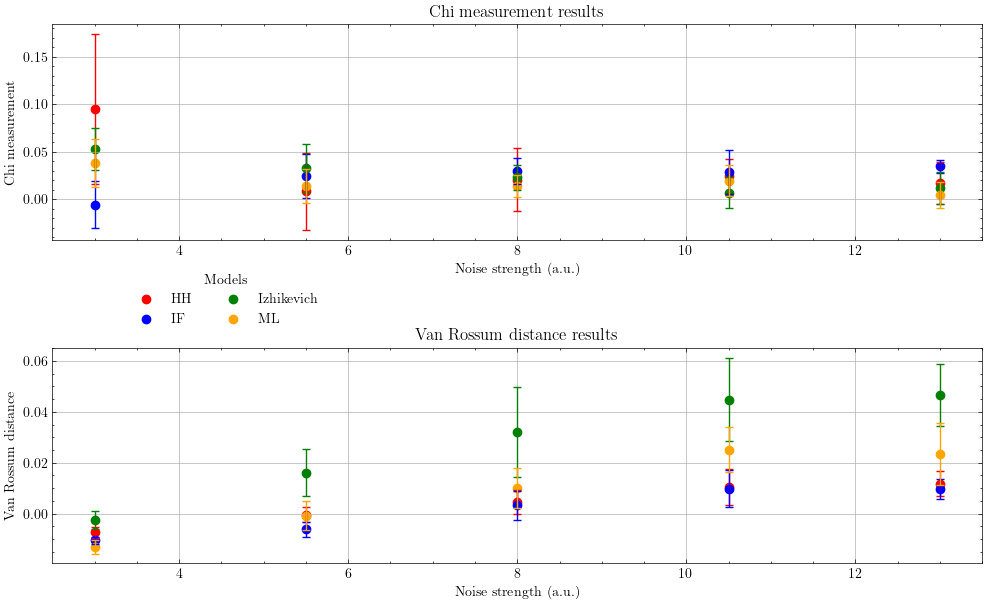

In [35]:
k = np.linspace(3,13,5)
fig, (ax1, ax2) = plt.subplots(2,1)

plt.title('Experiment 3 - Evolution of the synchronisation in function of noise')
fig.subplots_adjust(hspace=0.5)
ax1.set_xlabel('Noise strength (a.u.)')
ax2.set_xlabel('Noise strength (a.u.) ')
ax1.set_ylabel('Chi measurement')
ax2.set_ylabel('Van Rossum distance')
ax1.tick_params(axis = 'y')
ax2.tick_params(axis = 'y')

ax1.title.set_text('Chi measurement results')
ax2.title.set_text('Van Rossum distance results')

ln1 = ax1.scatter(k,chi_HH_noise[:,0],color = 'r', label = 'HH')
ax1.errorbar(k,chi_HH_noise[:,0],yerr=chi_HH_noise[:,1], fmt='none',capsize=3,color = 'r')
ln2 = ax1.scatter(k,chi_IF_noise[:,0],color = 'b', label = 'IF')
ax1.errorbar(k,chi_IF_noise[:,0],yerr=chi_IF_noise[:,1], fmt='none',capsize=3,color = 'b')
ln3 = ax1.scatter(k,chi_IZH_noise[:,0],color = 'g', label = 'Izhikevich')
ax1.errorbar(k,chi_IZH_noise[:,0],yerr=chi_IZH_noise[:,1], fmt='none',capsize=3,color = 'g')
ln4 = ax1.scatter(k,chi_ML_noise[:,0],color = 'orange', label = 'ML')
ax1.errorbar(k,chi_ML_noise[:,0],yerr=chi_ML_noise[:,1], fmt='none',capsize=3,color = 'orange')


ax2.scatter(k,rossum_HH_noise[:,0],color = 'r', label = 'HH')
ax2.errorbar(k,rossum_HH_noise[:,0],yerr=rossum_HH_noise[:,1], fmt='none',capsize=3,color = 'r')
ax2.scatter(k,rossum_IF_noise[:,0],color = 'b', label = 'IF')
ax2.errorbar(k,rossum_IF_noise[:,0],yerr=rossum_IF_noise[:,1], fmt='none',capsize=3,color = 'b')
ax2.scatter(k,rossum_IZH_noise[:,0],color = 'g', label = 'Izhikevich')
ax2.errorbar(k,rossum_IZH_noise[:,0],yerr=rossum_IZH_noise[:,1], fmt='none',capsize=3,color = 'g')
ax2.scatter(k,rossum_ML_noise[:,0],color = 'orange', label = 'ML')
ax2.errorbar(k,rossum_ML_noise[:,0],yerr=rossum_ML_noise[:,1], fmt='none',capsize=3,color = 'orange')


ax1.grid()
ax2.grid()
ax1.legend(title='Models',bbox_to_anchor =( 0.3,-0.1), ncols = 2 )
plt.show()

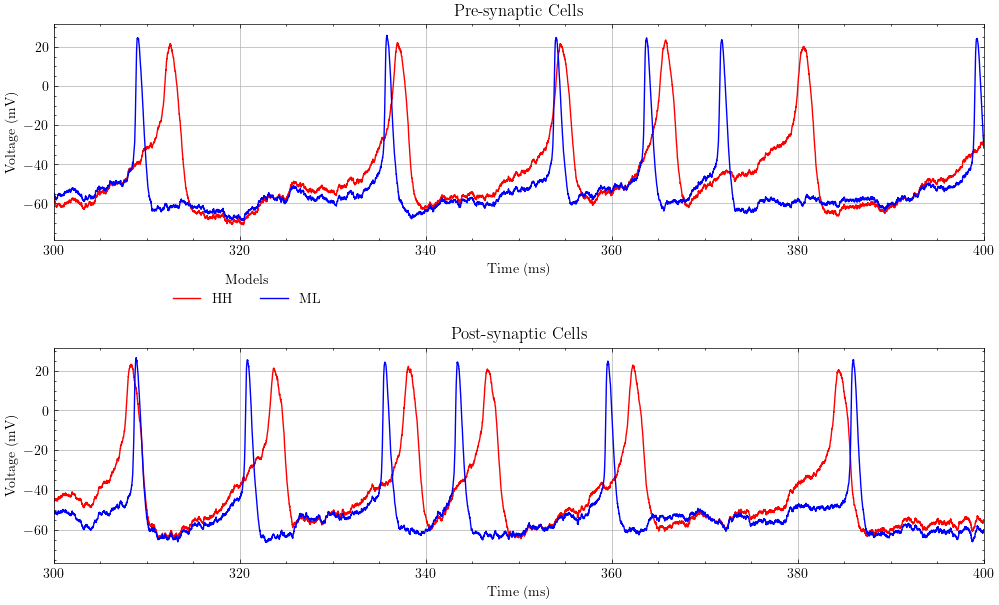

In [59]:
k = np.linspace(0.008,0.058,5)
fig, (ax1, ax2) = plt.subplots(2,1)

plt.title('Experiment 3 - Volt traces Comparisson')
fig.subplots_adjust(hspace=0.5)
ax1.set_xlabel('Time (ms)')
ax2.set_xlabel('Time (ms) ')
ax1.set_ylabel('Voltage (mV)')
ax2.set_ylabel('Voltage (mV)')
ax1.tick_params(axis = 'y')
ax2.tick_params(axis = 'y')

ax1.title.set_text('Pre-synaptic Cells')
ax2.title.set_text('Post-synaptic Cells')

ax1.plot(t,save_HH_noise[4][:,0],color = 'r', label = 'HH')
ax1.plot(t,save_ML_noise[4][:,0],color = 'b', label = 'ML')
ax1.set_xlim(300,400)


ax2.plot(t,save_HH_noise[4][:,1],color = 'r', label = 'HH')
ax2.plot(t,save_ML_noise[4][:,1],color = 'b', label = 'ML')
ax2.set_xlim(300,400)

ax1.grid()
ax2.grid()
ax1.legend(title='Models',bbox_to_anchor =( 0.3,-0.1), ncols = 2 )
plt.show()

In [ ]:
spike_HH_1 =  (np.argwhere(np.array(matrix_HH_k[4])[0,:]>0) * dt).flatten()
spike_HH_2 =  (np.argwhere(np.array(matrix_HH_k[4])[1,:]>0) * dt).flatten()
spike_IF_1 =  (np.argwhere(np.array(matrix_IF_k[4])[0,:]>0) * dt).flatten()
spike_IF_2 =  (np.argwhere(np.array(matrix_IF_k[4])[1,:]>0) * dt).flatten()
spike_IZH_1 =  (np.argwhere(np.array(matrix_IZH_k[4])[0,:]>0) * dt).flatten()
spike_IZH_2 = (np.argwhere(np.array(matrix_IZH_k[4])[1,:]>0) * dt).flatten()
spike_ML_1 = (np.argwhere(np.array(matrix_ML_k[4])[0,:]>0) * dt).flatten()
spike_ML_2 = (np.argwhere(np.array(matrix_ML_k[4])[1,:]>0) * dt).flatten()
fig, ax = plt.subplots()

ax.eventplot(spike_HH_1, color = '#5B84B1FF')
ax.eventplot(spike_HH_2,color='#FC766AFF',lineoffsets=0,label='hola')
ax.eventplot(spike_IF_2,color = '#FC766AFF',lineoffsets=2.5)
ax.eventplot(spike_IF_1, color = '#5B84B1FF', lineoffsets= 3.5)
ax.eventplot(spike_IZH_2,color = '#FC766AFF',lineoffsets= 5.0 )
ax.eventplot(spike_IZH_1, color = '#5B84B1FF', lineoffsets= 6.0)
ax.eventplot(spike_ML_2, color = '#FC766AFF', lineoffsets= 7.5)
ax.eventplot(spike_ML_1,color = '#5B84B1FF', lineoffsets= 8.5)
ax.grid()
ax.set_ylim(-0.6,9.1)
ax.set_ylabel('Models (upper: pre-synaptic, lower: post-synaptic)')
plt.yticks((0.5,3.0,5.5,8.0))
labels = [item.get_text() for item in ax.get_yticklabels()]
labels[0] = 'HH'
labels[1] = 'LIF'
labels[2] = 'IZH'
labels[3] = 'ML'

ax.set_yticklabels(labels, color = 'black')
ax.set_xlabel('Spike times (ms)')
ax.set_xlim(0,1500)

plt.title('Spike times for the four models-test for k = 0.058')
plt.show()